#### **Imports**

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import cluster 
import seaborn as sns
import random
from yellowbrick.cluster import KElbowVisualizer

#### **Define euclidean distance**

In [12]:
def euclidean_distance(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
    """
    return np.sqrt(np.sum((point - data)**2, axis=-1))

def minkowski_distance(x, y, p=4):
#     """
#     Calculates the Minkowski distance between two points x and y. 
#     The parameter p is used to define the order of the distance metric. 

#     Parameters: 
#     x (array): First point 
#     y (array): Second point 
#     p (int): Order of the distance metric

#     Returns: 
#     float: Minkowski distance between x and y with order p
#     """
    return np.power(np.sum(np.abs(np.power(x - y, p)), axis=-1), 1.0/p)


class KMeans:
    @staticmethod
    def euclidean_distance(point, data, axis=-1):
        """
        Euclidean distance between point & data.
        Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).
        """
        return np.sqrt(np.sum((point - data)**2, axis=axis))

    @staticmethod
    def minkowski_distance(x, y, p=4, axis=-1):
        """
        Calculates the Minkowski distance between two points x and y. 
        The parameter p is used to define the order of the distance metric. 

        Parameters: 
        x (array): First point 
        y (array): Second point 
        p (int): Order of the distance metric

        Returns: 
        float: Minkowski distance between x and y with order p
        """
        return np.power(np.sum(np.abs(np.power(x - y, p)), axis=axis), 1.0/p)


    def __init__(self, n_clusters=2, metric=minkowski_distance, init='k-means++', max_iter=300, tol=1e-8):
        self.n_clusters = n_clusters
        self.metric = metric
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None

    def _init_centers(self, X):
        if self.init == 'k-means++':
            centers = [X[np.random.randint(X.shape[0])]]
            while len(centers) < self.n_clusters:
                # distances = np.array([min([np.linalg.norm(x-c)**2 for c in centers]) for x in X])
                distances = np.array([min([self.metric(x, c) for c in centers]) for x in X])
                probs = distances / distances.sum()
                cumprobs = probs.cumsum()
                r = np.random.rand()
                for j, p in enumerate(cumprobs):
                    if r < p:
                        centers.append(X[j])
                        break
        elif self.init == 'random':
            centers = X[np.random.choice(X.shape[0], self.n_clusters, replace=False), :]
        else:
            raise ValueError("Invalid value for 'init' parameter")

        return np.array(centers)

    def get_functional_accuracy_(self, X, labels, centers):
        elements_in_clusters = np.array([X[np.where(labels == i)] for i in range(self.n_clusters)])
        return np.sum([([minkowski_distance(k, j, 4) for k in i]) \
                for i, j in zip(elements_in_clusters, centers)])

    def fit(self, X):
        centers = self._init_centers(X)
        for i in range(self.max_iter):
            new_accuracy = None
            distances = np.array([self.metric(X, c, axis=1) for c in centers]).T
            self.labels_ = np.argmin(distances, axis=1)
            new_centers = np.array([X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)])
            accuracy = self.get_functional_accuracy_(X, self.labels_, new_centers)
            if new_accuracy:
                if abs(new_accuracy - accuracy) < self.tol:
                    break
            centers = new_centers
            new_accuracy = accuracy

        self.cluster_centers_ = centers
        self.inertia_ = np.sum(np.min(distances, axis=1))

    def predict(self, X):
        # distances = np.array([np.linalg.norm(X - c, axis=1) for c in self.cluster_centers_]).T
        distances = np.array([self.metric(X, c, axis=1) for c in self.cluster_centers_]).T
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

    def transform(self, X):
        # distances = np.array([np.linalg.norm(X - c, axis=1) for c in self.cluster_centers_]).T
        distances = np.array([self.metric(X, c, axis=1) for c in self.cluster_centers_]).T
        return np.min(distances, axis=1)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def score(self, X):
        # distances = np.array([np.linalg.norm(X - c, axis=1) for c in self.cluster_centers_]).T
        distances = np.array([self.metric(X, c, axis=1) for c in self.cluster_centers_]).T
        return -np.sum(np.min(distances, axis=1))

    def get_functional_accuracy(self, X):
        elements_in_clusters = np.array([X[np.where(self.labels_ == i)] for i in range(self.n_clusters)])
        return np.sum([([minkowski_distance(k, j, 4) for k in i]) \
                for i, j in zip(elements_in_clusters, self.cluster_centers_)])

    def get_distance_matrix(self, X):
        """
        This function calculates the matrix that contains distances to each cluster and its predicted cluster
        """
        distances = np.array([self.metric(X, c, axis=1) for c in self.cluster_centers_])
        return np.vstack((distances, self.labels_))

    def set_params(self, **params):
        if 'n_clusters' in params:
            self.n_clusters = params['n_clusters']
        if 'init' in params:
            self.init = params['init']
        if 'max_iter' in params:
            self.max_iter = params['max_iter']
        if 'tol' in params:
            self.tol = params['tol']

    def get_params(self):
        return {'n_clusters': self.n_clusters,
                'init': self.init,
                'max_iter': self.max_iter,
                'tol': self.tol}

#### **Read data**

In [13]:
import pandas as pd
data = pd.read_csv("data10.txt", sep="   ", header=None)
data.head()

C:\Users\Arseny\AppData\Local\Temp\ipykernel_23024\2707670962.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv("data10.txt", sep="   ", header=None)


,0,1
0,0.143757,0.595984
1,0.992234,3.105658
2,1.006230,0.505011
3,0.851919,2.779120
4,-0.035382,0.847391


#### **Plot data**

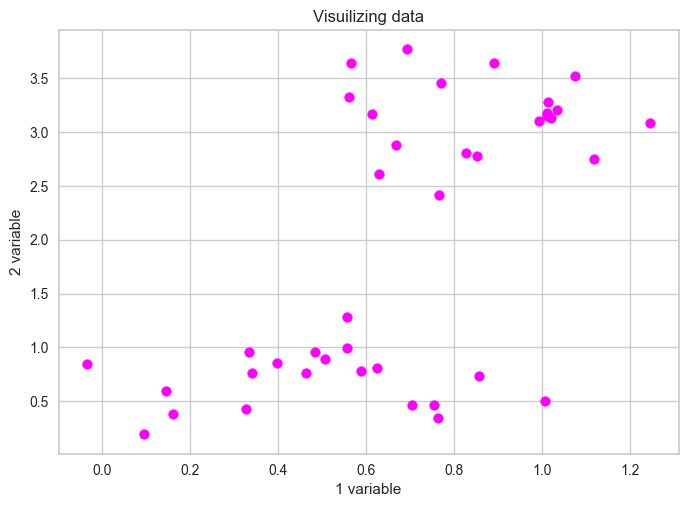

In [14]:
plt.scatter((data.T).iloc[0, :], (data.T).iloc[1, :], c="magenta")
plt.title("Visuilizing data")
plt.xlabel("1 variable")
plt.ylabel("2 variable")
plt.grid(0.1)

#### **Standardize data (recommended way also for k-means, but for this approach this is not needed)**

In [15]:
standard_data = StandardScaler().fit_transform(data)
standard_data[:10]

array([[-1.75856421, -1.05088095],
       [ 1.05366023,  0.93749551],
       [ 1.10004651, -1.12295705],
       [ 0.58859499,  0.67878441],
       [-2.35231093, -0.85169455],
       [-0.14765354,  0.54496157],
       [-0.38887173, -0.73688007],
       [ 0.06211166,  1.4629181 ],
       [-0.63521357, -0.76664913],
       [ 0.71559727,  1.36079375]])

#### **Plot new data**

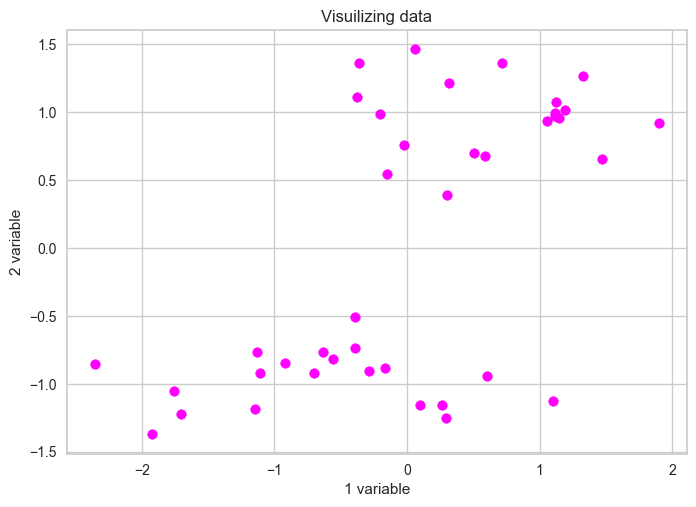

In [16]:
plt.scatter(standard_data[:, 0], standard_data[:, 1], c="magenta")
plt.title("Visuilizing data")
plt.xlabel("1 variable")
plt.ylabel("2 variable")
plt.grid(0.1)

#### **Find number of clusters with elbow method**

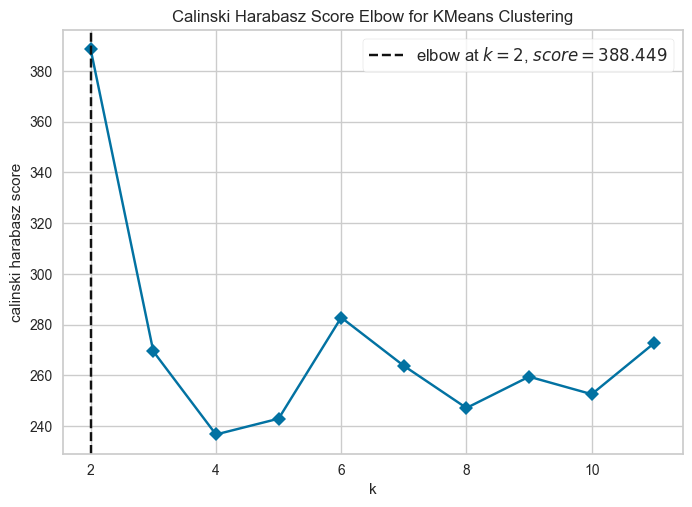

2

In [17]:
model = cluster.KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,12), metric='calinski_harabasz', timings=False
)
visualizer.fit(data)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure
visualizer.elbow_value_

#### **Apply number of clusters to model class**

Clusters centers are: [array([0.48110614, 0.69897813]), array([0.86756226, 3.14577568])]
The functional accuracy is: 12.99


C:\Users\Arseny\AppData\Local\Temp\ipykernel_23024\2169487149.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elements_in_clusters = np.array([X[np.where(labels == i)] for i in range(self.n_clusters)])
c:\Users\Arseny\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


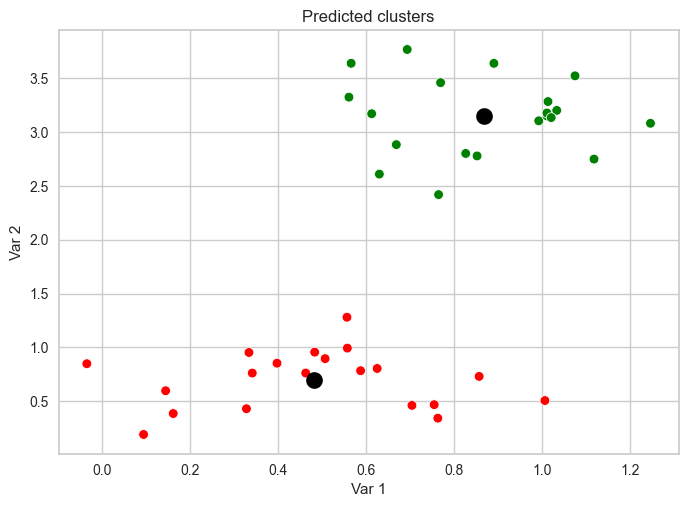

In [18]:
N = visualizer.elbow_value_
# Fit centroids to dataset
kmeans = KMeans(n_clusters=N, init="random")
kmeans.fit(data.to_numpy())
# View results
class_centers = kmeans.cluster_centers_
classification = kmeans.predict(data.to_numpy())
class_labels = kmeans.labels_
sns.scatterplot(x=[X[0] for X in data.to_numpy()],
                y=[X[1] for X in data.to_numpy()],
                c=np.array(["red", "green", "blue"])[classification],
                legend=None)
plt.scatter([x for x, _ in kmeans.cluster_centers_],
         [y for _, y in kmeans.cluster_centers_],
         c="black",
         linewidths=5)
print(f"Clusters centers are: {[i for i in kmeans.cluster_centers_]}")

print(f"The functional accuracy is: {kmeans.get_functional_accuracy(data.to_numpy()):.2f}")

plt.grid(0.1)
plt.title("Predicted clusters")
plt.xlabel("Var 1")
plt.ylabel("Var 2")
plt.show()

In [19]:
classification

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int64)

#### **To check if hypotezis is right i calculate accuracy functional for implementation of k-means from standard library of packages**

In [20]:
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=2, random_state=0, init="random").fit(data)

# centers = kmeans.cluster_centers_
# labels = kmeans.labels_

# elements_in_clusters = np.array([data.to_numpy()[np.where(labels == i)] for i in range(2)])
# inertia = np.sum([([minkowski_distance(k, j, 4) for k in i]) \
#                 for i, j in zip(elements_in_clusters, centers)])

# print(f"{inertia:.4f}")